In [19]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import applications
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
import keras
import glob
import matplotlib.pyplot as plt
from skimage.io import imread
from keras.callbacks import ModelCheckpoint
from skimage import exposure
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [20]:
# dimensions of our images.
img_width, img_height = 512, 512

weights_path = '../saved_weights/vgg16_weights.h5'
top_model_weights_path = '../saved_weights/bottleneck_fc_model.h5'
train_data_dir = '../data/model/key19/train'
validation_data_dir = '../data/model/key19/validation'
test_data_dir = '../data/model/key19/test'
nb_train_samples = int(len(glob.glob(train_data_dir+'/*/*')))
nb_validation_samples = int(len(glob.glob(validation_data_dir+'/*/*')))
nb_test_samples = int(len(glob.glob(test_data_dir+'/*/*')))
epochs = 1000
batch_size = 8
print('Found {} training samples, {} validation samples and {} test samples'.format(nb_train_samples,nb_validation_samples, nb_test_samples))

Found 429 training samples, 142 validation samples and 0 test samples


In [21]:
# number of files in each folder
nb_train_sub_samples = np.zeros(6)
nb_validation_sub_samples = np.zeros(6)
for i in range(1,7):
    path_train = train_data_dir+'/pos'+str(i)+'/*.png'
    path_validation = validation_data_dir+'/pos'+str(i)+'/*.png'
    nb_train_sub_samples[i-1] = int(len(glob.glob(path_train)))
    nb_validation_sub_samples[i-1] = int(len(glob.glob(path_validation)))

In [22]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        
        #self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure()
        plt.plot(self.x, self.losses, label="train_loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(self.x, self.train_acc, label="train_acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [23]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))
print('Model loaded.')

Model loaded.


In [24]:
for layer in base_model.layers[0:7]:
    layer.trainable = False
    
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [25]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()

top_model.add(Flatten(input_shape=base_model.output_shape[1:]))

#top_model.add(Dense(512,kernel_regularizer=regularizers.l2(0.001)))
#top_model.add(BatchNormalization())
#top_model.add(Activation('relu'))
#top_model.add(Dropout(0.8))

top_model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))
top_model.add(Dropout(0.7))

top_model.add(Dense(6, kernel_regularizer=regularizers.l2(0.001)))
top_model.add(Activation('softmax'))

In [26]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [27]:
#top_model.summary()

In [28]:
# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs=top_model(base_model.output))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [30]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [31]:
train_datagen = ImageDataGenerator(
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.05,
                                    vertical_flip=True,
                                    rescale=1/255.,
                                    fill_mode='nearest',
                                    channel_shift_range=0.2*255)

validation_datagen = ImageDataGenerator(rescale=1/255.)

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

Found 429 images belonging to 6 classes.


In [45]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='categorical')

Found 142 images belonging to 6 classes.


In [34]:
checkpointer = ModelCheckpoint(filepath='../saved_weights/VGG16_key19_weights.hdf5', verbose=1, save_best_only=True)

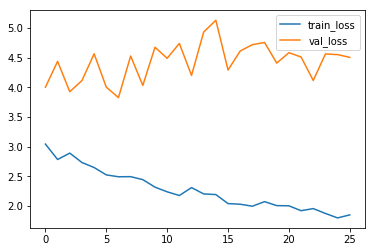

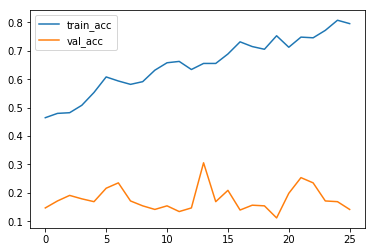

53/53 [==============================] - 48s - loss: 1.8474 - acc: 0.7958 - val_loss: 4.5042 - val_acc: 0.1418
Epoch 27/1000
11/53 [=====>........................] - ETA: 33s - loss: 1.6066 - acc: 0.8750

KeyboardInterrupt: 

In [35]:
# fine-tune the model
train_history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // 8,
    callbacks=[checkpointer, plot_losses])

In [48]:
for batch, classes in train_generator:
    batch
    break
train_generator.filenames[0:8]

['pos1\\19_16_18_22_24_17_L_H_H_L_L_H_0579_0_2839.png',
 'pos1\\19_16_18_22_24_17_L_H_H_L_L_H_0580_0_7225.png',
 'pos1\\19_16_18_22_24_17_L_H_H_L_L_H_0581_0_1632.png',
 'pos1\\19_16_18_22_24_17_L_H_H_L_L_H_0582_0_940.png',
 'pos1\\19_16_18_22_24_17_L_H_H_L_L_H_0583_0_4829.png',
 'pos1\\19_16_24_18_17_22_H_H_H_H_H_H_10_0_7390.png',
 'pos1\\19_16_24_18_17_22_H_H_H_H_H_H_11_0_6899.png',
 'pos1\\19_16_24_18_17_22_H_H_H_H_H_H_12_0_2779.png']

[ 1.  0.  0.  0.  0.  0.]


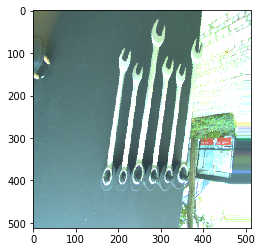

[ 1.  0.  0.  0.  0.  0.]


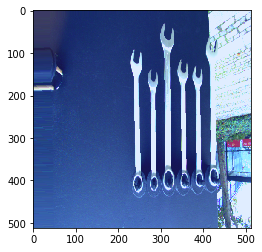

[ 1.  0.  0.  0.  0.  0.]


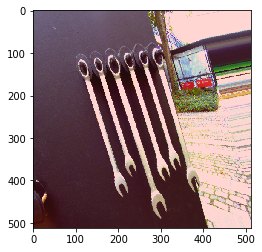

[ 1.  0.  0.  0.  0.  0.]


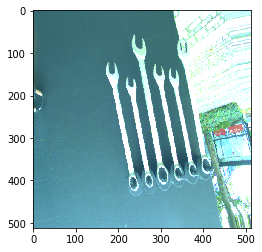

[ 1.  0.  0.  0.  0.  0.]


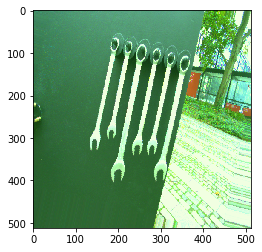

[ 1.  0.  0.  0.  0.  0.]


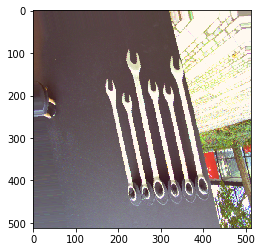

[ 1.  0.  0.  0.  0.  0.]


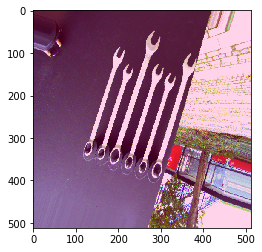

[ 1.  0.  0.  0.  0.  0.]


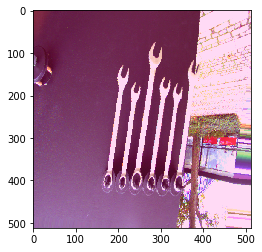

In [49]:
for i in range(0,8):
    print(classes[i])
    plt.figure()
    plt.imshow(batch[i][:])
    plt.show()


In [37]:
classes

array([[ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [16]:
#model.save_weights('transfer_key19_99_6p_2.h5')
print('Done')
model.load_weights('../saved_weights/VGG16_key19_weights.hdf5')

Done


In [ ]:
model.load_weights('../saved_weights/VGG16_key19_weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, 
                                steps = nb_validation_samples // batch_size)
print()
print('Validation Loss:', loss)
print('Validation Accuracy', accuracy)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')
val_pred_prob = model.predict_generator(validation_generator,steps = nb_validation_samples, verbose=1)
val_pred_labels = np.argmax(val_pred_prob, axis=-1)

In [ ]:
acc = 1-np.sum(val_pred_labels!=validation_generator.classes[:nb_validation_samples])/nb_validation_samples
acc

In [ ]:
idx = np.array(np.where(val_pred_labels!=validation_generator.classes))
for i in range(0,idx.shape[1]):
    print(validation_generator.filenames[idx[0,i]])

In [24]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 18 images belonging to 6 classes.


In [25]:
test_pred_prob = model.predict_generator(test_generator,steps = nb_test_samples, verbose=1)
test_pred_labels = np.argmax(test_pred_prob, axis=-1)

16/18 [=========================>....] - ETA: 0s

In [26]:
acc = 1-np.sum(test_pred_labels!=test_generator.classes[:nb_test_samples])/nb_test_samples
acc

0.16666666666666663

In [ ]:
idx = np.array(np.where(test_pred_labels!=test_generator.classes))
for i in range(0,idx.shape[1]):
    print(test_generator.filenames[idx[0,i]])

# Loading model

In [ ]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))
print('Model loaded.')

In [ ]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(6, activation='softmax'))

In [ ]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [ ]:
# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs=top_model(base_model.output))

In [ ]:
model.load_weights('../saved_weights/VGG16_key19_weights.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=subtractmean)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

In [ ]:
test_pred_prob = model.predict_generator(test_generator,steps = nb_test_samples, verbose=1)
test_pred_labels = np.argmax(test_pred_prob, axis=-1)

In [ ]:
acc = 1-np.sum(test_pred_labels!=test_generator.classes[:nb_test_samples])/nb_test_samples
acc

In [ ]:
idx = np.array(np.where(test_pred_labels!=test_generator.classes))
for i in range(0,idx.shape[1]):
    print('Classified as pos {}'.format(test_pred_labels[idx[0,i]]+1))
    filename = '../data/model/key19/test/'+test_generator.filenames[idx[0,i]]
    plt.figure()
    image = imread(filename)
    plt.imshow(image)
    plt.title(filename)
    plt.axis('off')
    plt.show()
    


In [ ]:
model.save('VGG16.h5')

# This is for creating the model init weights

In [14]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.05,
                                    vertical_flip=True,
                                    rescale=1/255.,
                                    fill_mode='nearest',
                                    channel_shift_range=0.2*255)

validation_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

epochs = 15

Found 429 images belonging to 6 classes.
Found 142 images belonging to 6 classes.


In [15]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.05,
                                    vertical_flip=True,
                                    rescale=1/255.,
                                    fill_mode='nearest',
                                    channel_shift_range=0.2*255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size, verbose=1)
    
    np.save(open('../saved_weights/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size, verbose=1)
    np.save(open('../saved_weights/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [16]:
def train_top_model():
    train_data = np.load(open('../saved_weights/bottleneck_features_train.npy','rb'))
    train_labels = np.array([[1,0,0,0,0,0]] * nb_train_sub_samples[0].astype(int) + 
                            [[0,1,0,0,0,0]] * nb_train_sub_samples[1].astype(int) +
                            [[0,0,1,0,0,0]] * nb_train_sub_samples[2].astype(int) + 
                            [[0,0,0,1,0,0]] * nb_train_sub_samples[3].astype(int) +
                            [[0,0,0,0,1,0]] * nb_train_sub_samples[4].astype(int) + 
                            [[0,0,0,0,0,1]] * nb_train_sub_samples[5].astype(int))
    train_labels = train_labels[0:nb_train_samples // batch_size * batch_size]

    validation_data = np.load(open('../saved_weights/bottleneck_features_validation.npy','rb'))
    validation_labels = np.array([[1,0,0,0,0,0]] * nb_validation_sub_samples[0].astype(int) + 
                                 [[0,1,0,0,0,0]] * nb_validation_sub_samples[1].astype(int) +
                                 [[0,0,1,0,0,0]] * nb_validation_sub_samples[2].astype(int) + 
                                 [[0,0,0,1,0,0]] * nb_validation_sub_samples[3].astype(int) +
                                 [[0,0,0,0,1,0]] * nb_validation_sub_samples[4].astype(int) + 
                                 [[0,0,0,0,0,1]] * nb_validation_sub_samples[5].astype(int))
    validation_labels = validation_labels[0:nb_validation_samples // batch_size * batch_size]

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    
    #model.add(Dense(512,kernel_regularizer=regularizers.l2(0.0005)))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.8))
    
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    
    model.add(Dense(6, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [17]:
save_bottlebeck_features()

Found 429 images belonging to 6 classes.
53/53 [==============================] - 26s    
Found 142 images belonging to 6 classes.
17/17 [==============================] - 8s     


In [18]:
train_top_model()

Train on 424 samples, validate on 136 samples
Epoch 1/15
424/424 [==============================] - 4s - loss: 3.3271 - acc: 0.2877 - val_loss: 6.6054 - val_acc: 0.2794
Epoch 2/15
424/424 [==============================] - 3s - loss: 2.6527 - acc: 0.4906 - val_loss: 4.3079 - val_acc: 0.2794
Epoch 3/15
424/424 [==============================] - 3s - loss: 2.4115 - acc: 0.6085 - val_loss: 3.7060 - val_acc: 0.2868
Epoch 4/15
424/424 [==============================] - 3s - loss: 2.0716 - acc: 0.7075 - val_loss: 3.3742 - val_acc: 0.2132
Epoch 5/15
424/424 [==============================] - 3s - loss: 1.9248 - acc: 0.7665 - val_loss: 3.5630 - val_acc: 0.1912
Epoch 6/15
424/424 [==============================] - 3s - loss: 1.8154 - acc: 0.7618 - val_loss: 3.3510 - val_acc: 0.1838
Epoch 7/15
424/424 [==============================] - 3s - loss: 1.7513 - acc: 0.7783 - val_loss: 3.3416 - val_acc: 0.1765
Epoch 8/15
424/424 [==============================] - 3s - loss: 1.6323 - acc: 0.8396 - val_l